In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import yaml
import pickle as pk
import json

%matplotlib inline

In [3]:
%cd C:\Users\USER\Desktop\python codes\group 2 paper review\Water_Portability_Prediction

C:\Users\USER\Desktop\python codes\group 2 paper review\Water_Portability_Prediction


In [4]:
df = pd.read_csv(r"data\raw\water_potability.csv")

In [5]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [6]:
ph_mean = df[df['Potability'] == 0]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['ph'].isna()), 'ph'] = ph_mean

ph_mean_1 = df[df['Potability'] == 1]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['ph'].isna()), 'ph'] = ph_mean_1

sulf_mean = df[df['Potability'] == 0]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Sulfate'].isna()), 'Sulfate'] = sulf_mean

sulf_mean_1 = df[df['Potability'] == 1]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Sulfate'].isna()), 'Sulfate'] = sulf_mean_1

traih_mean = df[df['Potability'] == 0]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Trihalomethanes'].isna()), 'Trihalomethanes'] = traih_mean

trah_mean_1 = df[df['Potability'] == 1]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Trihalomethanes'].isna()), 'Trihalomethanes'] = trah_mean_1

In [7]:
X = df.drop(columns="Potability")
y = df["Potability"]

In [8]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=10)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
test = X_test

In [10]:
test.to_csv(config["paths"]["test_data"], index=False)

NameError: name 'config' is not defined

In [11]:
print(y_train.shape)
print(y_test.shape)

(2620,)
(656,)


In [12]:
y_train.value_counts(normalize=True)

0    0.609924
1    0.390076
Name: Potability, dtype: float64

In [13]:
# standard scaling
scaler = StandardScaler()

In [14]:
# Imputer
imputer = SimpleImputer(strategy="median")

In [15]:
# random forest model
model_rf = RandomForestClassifier(random_state=234)

In [16]:
# xgboost model
model_xgb = XGBClassifier(random_state=234)

In [17]:
# lightgbm model
model_lgbm = LGBMClassifier(random_state=234)

In [18]:
# Extra tree
model_extra_tree = ExtraTreeClassifier(random_state=234)
clf = BaggingClassifier(model_extra_tree, random_state=234)

In [19]:
# random forest pipeline
pipe_rf = make_pipeline(imputer, scaler, model_rf)

In [20]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=234))])

In [21]:
metrics = classification_report(y_test, pipe_rf.predict(X_test))
print(metrics)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       400
           1       0.81      0.69      0.75       256

    accuracy                           0.82       656
   macro avg       0.81      0.79      0.80       656
weighted avg       0.81      0.82      0.81       656



In [26]:
metrics

'              precision    recall  f1-score   support\n\n           0       0.82      0.90      0.86       400\n           1       0.81      0.69      0.75       256\n\n    accuracy                           0.82       656\n   macro avg       0.81      0.79      0.80       656\nweighted avg       0.81      0.82      0.81       656\n'

In [23]:
with open(config["paths"]["metrics"], "w") as file:
    json.dump({"metrics": metrics}, file)

NameError: name 'config' is not defined

In [24]:
with open("params.yaml") as file:
    config = yaml.safe_load(file)

In [25]:
config

{'paths': {'data': 'data/raw/water_potability.csv',
  'model': 'models/model.pk',
  'test_data': 'data/test/test_data.csv',
  'train_data': 'data/train/test_data.csv',
  'confusion_matrix': 'report/visual/confusion_matrix.jpg',
  'roc_curve': 'report/visual/rocauc_curve.jpg',
  'metrics': 'report/metrics/metrics.json'},
 'loglevel': 'INFO',
 'train': {'seeds': 234, 'test_size': 0.2, 'imputer': 'median', 'n_split': 10}}

In [15]:
with open(config["paths"]["model"], "wb") as file:
    pk.dump(pipe_rf, file)

In [21]:
print('saving the model to ' + config["paths"]["model"] + "...")

saving the model to model/model.pk...


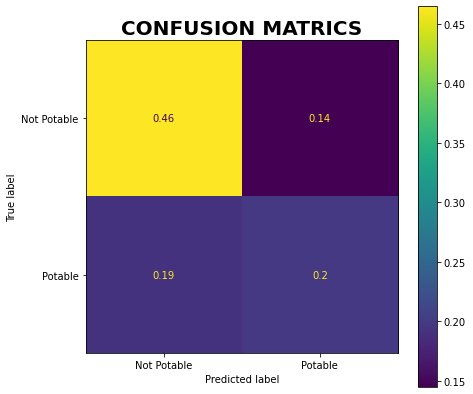

In [53]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test, normalize='all', labels=[0, 1], display_labels=["Not Potable", "Potable"], ax=ax)
plt.title("Confusion Matrics".upper(), size=20, weight="bold")
plt.savefig(config["paths"]["confusion_matrix"])

In [45]:
pipe_rf.predict_proba(X_test)[:, 0]

array([0.72, 0.39, 0.69, 0.5 , 0.34, 0.35, 0.21, 0.56, 0.65, 0.68, 0.64,
       0.67, 0.87, 0.51, 0.65, 0.52, 0.57, 0.66, 0.74, 0.51, 0.37, 0.47,
       0.61, 0.43, 0.37, 0.61, 0.49, 0.43, 0.64, 0.53, 0.48, 0.65, 0.5 ,
       0.65, 0.4 , 0.54, 0.56, 0.63, 0.43, 0.34, 0.67, 0.78, 0.52, 0.53,
       0.77, 0.52, 0.42, 0.67, 0.87, 0.59, 0.26, 0.57, 0.64, 0.28, 0.44,
       0.59, 0.61, 0.76, 0.55, 0.55, 0.5 , 0.59, 0.58, 0.46, 0.29, 0.4 ,
       0.6 , 0.71, 0.67, 0.72, 0.26, 0.51, 0.77, 0.35, 0.6 , 0.6 , 0.65,
       0.66, 0.62, 0.83, 0.46, 0.57, 0.73, 0.54, 0.64, 0.4 , 0.75, 0.41,
       0.51, 0.59, 0.71, 0.56, 0.69, 0.49, 0.85, 0.52, 0.58, 0.51, 0.69,
       0.67, 0.62, 0.35, 0.35, 0.3 , 0.53, 0.74, 0.59, 0.54, 0.52, 0.75,
       0.7 , 0.69, 0.56, 0.61, 0.62, 0.37, 0.61, 0.46, 0.66, 0.27, 0.61,
       0.45, 0.74, 0.6 , 0.69, 0.32, 0.77, 0.62, 0.66, 0.44, 0.62, 0.63,
       0.29, 0.6 , 0.42, 0.59, 0.32, 0.59, 0.63, 0.47, 0.47, 0.42, 0.38,
       0.36, 0.78, 0.44, 0.71, 0.59, 0.66, 0.63, 0.

In [42]:
y_test.values.shape

(656,)

In [46]:
fpr, tpr, thresholds = roc_curve(y_test.values, pipe_rf.predict_proba(X_test)[:,0])

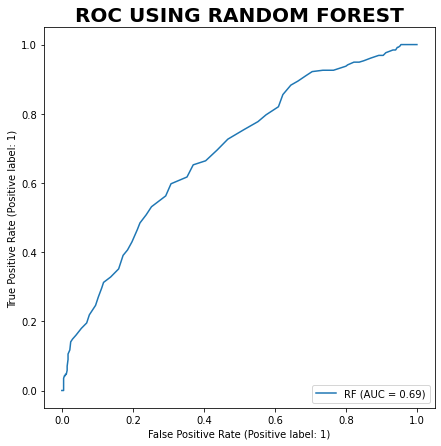

In [54]:
fig, ax = plt.subplots(figsize=(7,7))
RocCurveDisplay.from_estimator(estimator=pipe_rf, X=X_test, y=y_test, pos_label=1, name="RF", ax=ax)
plt.title("ROC using Random Forest".upper(), size=20, weight="bold")
plt.savefig(config["paths"]["roc_curve"]);

In [27]:
# random forest pipeline
pipe_xgb = make_pipeline(imputer, scaler, model_xgb)

In [28]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
         

In [29]:
print(classification_report(y_test, pipe_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       400
           1       0.78      0.72      0.75       256

    accuracy                           0.81       656
   macro avg       0.81      0.80      0.80       656
weighted avg       0.81      0.81      0.81       656



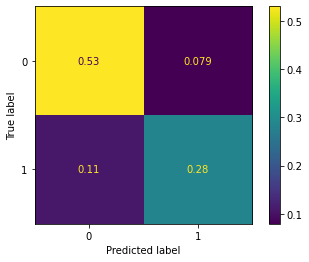

In [30]:
ConfusionMatrixDisplay.from_estimator(pipe_xgb, X_test, y_test, normalize='all')

In [32]:
# random forest pipeline
pipe_lgbm = make_pipeline(imputer, scaler, model_lgbm)

In [33]:
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=234))])

In [34]:
print(classification_report(y_test, pipe_lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       400
           1       0.78      0.68      0.73       256

    accuracy                           0.80       656
   macro avg       0.80      0.78      0.79       656
weighted avg       0.80      0.80      0.80       656



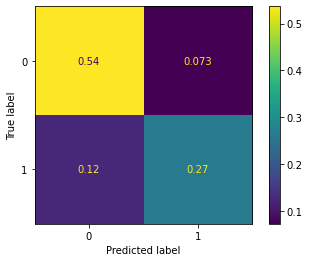

In [35]:
ConfusionMatrixDisplay.from_estimator(pipe_lgbm, X_test, y_test, normalize='all')

In [30]:
# random forest pipeline
pipe_extra_tree = make_pipeline(imputer, scaler, clf)

In [33]:
pipe_extra_tree.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=ExtraTreeClassifier(random_state=234),
                                   random_state=234))])

In [34]:
print(classification_report(y_test, pipe_extra_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.78      0.73       400
           1       0.58      0.48      0.52       256

    accuracy                           0.66       656
   macro avg       0.64      0.63      0.63       656
weighted avg       0.65      0.66      0.65       656



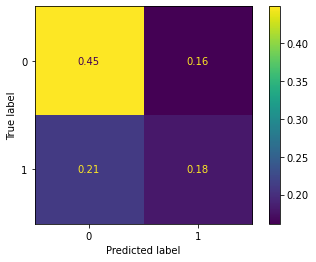

In [44]:
ConfusionMatrixDisplay.from_estimator(pipe_extra_tree, X_test, y_test, normalize='all')

In [46]:
estimators = [("rf", pipe_rf), 
              ("lgbm", pipe_lgbm), 
              ("xgb", pipe_xgb), 
              ("extra_tree", pipe_extra_tree)
              ]
stack = StackingClassifier(estimators=estimators, final_estimator=pipe_rf, cv=10, verbose=0, n_jobs=-1)
stack.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('rf',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(random_state=234))])),
                               ('lgbm',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('lgbmclassifier',
                                                 LGBM...
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('baggingclassifier',
                                                 BaggingClassifier(base_estimator=ExtraTreeClassifier(random_state=234),
                                                                   random_state=234))]))],
                   final_estimator=Pipeline(steps=[('simpleimputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('standardscaler',
                                                    StandardScaler()),
                                                   ('randomforestclassifier',
                                                    RandomForestClassifier(random_state=234))]),
                   n_jobs=-1)

In [47]:
print(classification_report(y_test, stack.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       400
           1       0.52      0.48      0.50       256

    accuracy                           0.62       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.62      0.62      0.62       656



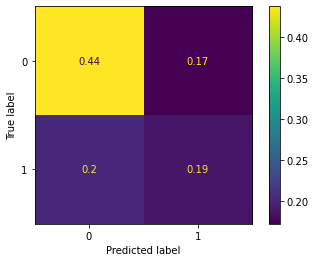

In [48]:
ConfusionMatrixDisplay.from_estimator(stack, X_test, y_test, normalize='all')